Transient Heat Transfer 1D
================

Let's get the process ID so that we can attach a debug later.

In [1]:
import os
print(os.getpid())

14568


In [2]:
file_content='''
from petsc4py.PETSc cimport Vec,  PetscVec
from petsc4py.PETSc cimport DM,   PetscDM
from petsc4py.PETSc cimport SNES, PetscSNES
from petsc4py.PETSc cimport TS,   PetscTS

from petsc4py.PETSc import Error

cdef extern from "HeatTransfer1Dimpl.h":
    ctypedef struct Params:
        double temperature_left_
        double temperature_right_
        double conductivity_
        double source_term_
        double wall_length_
        
    int FormInitGuess(PetscDM da, PetscVec x, Params *p)
    int FormFunction (PetscTS ts, double t, PetscVec X, PetscVec X_t, PetscVec F, Params *p)

def formInitGuess(Vec x, DM da, double temperature_left_, 
    double temperature_right_, double conductivity_, 
    double source_term_, double wall_length_):
    cdef int ierr
    cdef Params p = {
        "temperature_left_" : temperature_left_, 
        "temperature_right_" : temperature_right_, 
        "conductivity_" : conductivity_,
        "source_term_" : source_term_,
        "wall_length_" : wall_length_,
    }
    ierr = FormInitGuess(da.dm, x.vec, &p)
    if ierr != 0: raise Error(ierr)

def formFunction(TS ts, double t, Vec x, Vec x_t, Vec f, double temperature_left_, 
    double temperature_right_, double conductivity_, 
    double source_term_, double wall_length_):
    cdef int ierr
    cdef Params p = {
        "temperature_left_" : temperature_left_, 
        "temperature_right_" : temperature_right_, 
        "conductivity_" : conductivity_,
        "source_term_" : source_term_,
        "wall_length_" : wall_length_,
    }
    ierr = FormFunction(ts.ts, t, x.vec, x_t.vec, f.vec, &p)
    if ierr != 0: raise Error(ierr)
'''

text_file = open("HeatTransfer1D.pyx", "w")

text_file.write(file_content)

text_file.close()

In [3]:
# First you need to call
!python setup.py build_ext --inplace

running build_ext
running build_src
build_src
building extension "HeatTransfer1D" sources
cythonc:> .\HeatTransfer1D.c
build_src: building npy-pkg config files
No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
customize MSVCCompiler
customize MSVCCompiler using build_ext
building 'HeatTransfer1D' extension
compiling C sources
C:\Program Files (x86)\Microsoft Visual Studio 14.0\VC\BIN\x86_amd64\cl.exe /c /nologo /Ox /W3 /GL /DNDEBUG /MD -ID:\Miniconda3\envs\petsc_debug\Library\include -ID:\Miniconda3\envs\petsc_debug\Library\include\petsc\mpiuni -ID:\Miniconda3\envs\petsc_debug\lib\site-packages\petsc4py\include -I. -ID:\Miniconda3\envs\petsc_debug\lib\site-packages\numpy\core\include -ID:\Miniconda3\envs\petsc_debug\include -ID:\Miniconda3\envs\petsc_debug\include -I"C:\Program Files (x86)\Microsoft Visual Studio 14.0\VC\INCLUDE" -I"C:\Program Files (x86)\Windows Kits\10\include\10.0.14393.0\ucrt" -I"C:\Program Files (x86)\Windows Kits\NETFXSDK\4

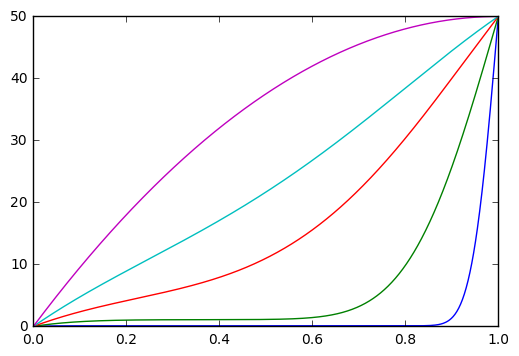

In [18]:
import sys
import numpy as np
import petsc4py
from petsc4py import PETSc
from matplotlib import pyplot as plt
import HeatTransfer1D

petsc4py.init(sys.argv)

def transient_heat_transfer_1D(
    nx, temperature_left, 
    temperature_right, 
    conductivity,
    source_term,
    wall_length,
    final_time,
    initial_time_step
    ):
    
    # Time Stepper (TS) for ODE and DAE
    # DAE - https://en.wikipedia.org/wiki/Differential_algebraic_equation
    # https://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/TS/
    ts = PETSc.TS().create()

    # http://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/DM/index.html
    da = PETSc.DMDA().create([nx],dof=1, stencil_width=1, stencil_type='star')
    ts.setDM(da)

    F = da.createGlobalVec()
    
    # http://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/TS/TSSetIFunction.html
    ts.setIFunction(HeatTransfer1D.formFunction, F,
                     args=(temperature_left, temperature_right, conductivity, source_term, wall_length))

    x = da.createGlobalVec()
    
    HeatTransfer1D.formInitGuess(x, da, temperature_left, temperature_right, conductivity, source_term, wall_length)

    # http://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/TS/TSSetDuration.html
    ts.setDuration(max_time=final_time, max_steps=None)
    
    # http://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/TS/TSSetExactFinalTime.html
    ts.setExactFinalTime(ts.ExactFinalTimeOption.STEPOVER)
    
    # http://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/TS/TSSetInitialTimeStep.html
    ts.setInitialTimeStep(initial_time=0.0, initial_time_step=initial_time_step)
    
    # http://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/TS/TSSetProblemType.html
    ts.setProblemType(ts.ProblemType.NONLINEAR)
    
    # Another way to set the solve type is through PETSc.Options()
    #ts.setType(ts.Type.CRANK_NICOLSON)
    #ts.setType(ts.Type.THETA)
    #ts.setTheta(theta=0.9999)
    #ts.setType(ts.Type.EIMEX) # http://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/TS/TSEIMEX.html
    #ts.setType(ts.Type.BDF      )

    ts.setFromOptions()

    ts.solve(x)

    return x

options = PETSc.Options()
options.clear()

dt = 0.001                 # [s]
dt_min = 1e-4              # [s]
dt_max = 0.1               # [s]

#ts_type = "beuler"
#ts_type = "pseudo" # http://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/TS/TSPSEUDO.html
#ts_type = "cn"
ts_type = "bdf"
options.setValue('-ts_type', ts_type)

options.setValue('-ts_bdf_order', 3) # https://en.wikipedia.org/wiki/Backward_differentiation_formula
options.setValue('-ts_adapt_type', 'basic') # basic or none
options.setValue('-ts_bdf_adapt', '')
options.setValue('-ts_adapt_dt_min', dt_min)
options.setValue('-ts_adapt_dt_max', dt_max)
options.setValue('-ts_monitor', None)

#options.delValue('-ts_bdf_adapt')

nx = 1000
temperature_left  = 0.0    # [degC]
temperature_right = 50.0   # [degC]
conductivity = 1.0         # [W/(m.K)]
source_term = 100.0          # [W/m3]
wall_length = 1.0          # [m]

time_intervals = [0.001, 0.01, 0.05, 0.1, 1.0]
sols = []
for final_time in time_intervals:
    sol = transient_heat_transfer_1D(
        nx, temperature_left, 
        temperature_right, 
        conductivity,
        source_term,
        wall_length,
        final_time,
        dt
        )
    sols.append(sol[...])
    
x = np.linspace(0, wall_length, nx)
for sol in sols:
    plt.plot(x, sol)
plt.show()